# Tâche 3 - Classification automatique de descriptions d'incidents

Cette tâche vise à classifier de courts textes décrivant des incidents qui se sont produits sur des chantiers de construction. Pour chaque incident, on retrouve une étiquette qui correspond au type d’incident (0 à 8). 

Les objectifs de cette tâche sont: 
- de se familiariser avec la classification de texte
- d'apprendre à utiliser les fonctions de base de scikit-learn
- de comprendre comment représenter un texte sous la forme d'un sac de mots (*bag of words*)
- de faire l'évaluation d'un modèle de classification avec un corpus de test
- de tenter d'interpréter les résultats d'un modèle à l'aide des poids d'attributs. 

Pour la première partie, vous devez construire une fonction (*train_and_test_classifier*) qui entraîne un modèle (les options étant la régression logistique et le naïf bayésien) et en faire l'évaluation sur des données d'entraînement et des données de test. Vous devez également évaluer l'impact de la lemmatisation de mots sur la performance des classificateurs. Deux fichiers de textes sont disponibles pour mener votre expérimentation (voir Section 1). 

Pour la deuxième partie, tentez de déterminer à quoi correspond chacune des classes d’incident. Faites une analyse des poids des modèles pour proposer des étiquettes pour chacune des classes. Vous pouvez vous inspirer des notebooks disponibles sur le site du cours. Expliquez clairement comment vous êtes arrivé à vos conclusions. L’important ici est de dégager le thème principal à partir de vos observations et non pas de trouver la formulation exacte des étiquettes. Veuillez noter que certaines classes sont (très) difficiles à identifier. 

Merci de respecter les signatures des fonctions *train_and_test_classifier* et *load_incident_dataset*.

Note sur la lemmatisation: Cette normalisation de texte nécessite l'utilisation d'un modèle qui repose sur l'apprentissage automatique. En conséquence, son temps d'exécution est plus long que le stemming. Si jamais cela ralentit trop vos expérimentations, il est possible de ne faire le traitement qu'une seule fois en sauvegardant les résultats après la première lemmatisation d'un fichier. Cela n'est toutefois pas exigé pour la remise de votre travail et ne sera pas évalué. 

## Section 1 - Lecture des fichiers de données

Voici les fichiers mis à votre disposition pour mener vos expérimentations. La fonction *load_incident_data* peut être utilisée pour lire les 2 fichiers (train et test). Rien à modifier dans cette section. 

In [145]:
import json

train_json_fn = "./data/t3_train.json"
test_json_fn = "./data/t3_test.json"


def load_incident_dataset(filename):
    with open(filename, 'r') as fp:
        incident_list = json.load(fp)
    return incident_list

In [146]:
train_list = load_incident_dataset(train_json_fn)
print("Nombre d'incidents:", len(train_list))
print("\nUn exemple:\n", train_list[10])

Nombre d'incidents: 2475

Un exemple:
 {'text': " At approximately 12:15 p.m. on February 8  2011  Employee # 1 and four other  coworkers were working in the West storage Facility at Enterprise Products  located at Mont Belvieu  Texas. A major fire began but Employee # 1 wasn't  able to escape. The recovery effort was delayed until the evening of February  10  2011  due to the presence of hydrocarbon vapors and small residual fires.   ", 'label': '6'}


In [147]:
test_list = load_incident_dataset(test_json_fn)
print("Nombre d'incidents", len(test_list))
incident = test_list[10]
print("\nUne description d'incident:", incident["text"])
print("\nSon étiquette:", incident["label"])

Nombre d'incidents 1062

Une description d'incident:  At approximately 2:00 p.m. on March 3  2005  Employee #1  an iron worker  was  performing connecting work at a height of approximately 14 ft above grade.  Employee #1 lost his balance and fell to the ground  landing on his feet. In  order to absorb the impact on his legs from the fall  Employee #1 bent down   striking his head on the spud wrench in the tool belt. He sustained 3 stitches  to his forehead  but he was not hospitalized.                                   

Son étiquette: 5


## Section 2 - Entraînement et évaluation des modèles  

Vous pouvez ajouter tout le code dont vous avez besoin pour l'entraînement. Merci de ne pas modifier la signature de la fonction d'entraînement et de bien expliquer votre démarche et vos résultats. N'oubliez pas de faire une recommandation de modèle. Vous pouvez ajouter des cellules au notebook si nécessaire. 

In [148]:
# Import spaCy
import spacy

# Charge la version anglaise de nlp 
nlp = spacy.load("en_core_web_sm")

def normalize_texts(texts, normalization):
    """
    :param texts: une liste de textes à normaliser
    :param normalization: la normalisation à appliquer ('words' ou 'lemma')
    :return: une liste de textes normalisés
    """
    normalized_texts = []
    for text in texts:
        if normalization == 'lemma':
            doc = nlp(text)
            normalized_text = ' '.join([token.lemma_ for token in doc])
        else:
            raise ValueError("Invalid normalization type. Allowed values are 'words' and 'lemma'.")
        normalized_texts.append(normalized_text)
    return normalized_texts

In [149]:
# Importer ici les librairies dont vous avez besoin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
import time



def train_and_test_classifier(train_fn, test_fn, model='NB', normalization='words'):
    """
    :param train_fn et test_fn: les 2 fichiers utilisées pour entraîner et tester les classificateurs.
    :param model: le type de classificateur. NB = Naive Bayes, LR = Régression logistique.
    :param normalization: la nomralisation appliquée aux mots des descriptions
                 - 'word': les mots des textes sans normalization.
                 - 'lemma': les lemmes des mots obtenus par lemmatisation avec Spacy.
    :return: un dictionnaire contenant 3 valeurs:
                 - l'accuracy à l'entraînement (validation croisée)
                 - l'accuracy sur le jeu de test
                 - la matrice de confusion calculée par scikit-learn sur les données de test
    """
    start_time = time.time()
    # Charger les données d'entraînement et de test
    train_list = load_incident_dataset(train_fn)
    test_list = load_incident_dataset(test_fn)

    # Extraire les textes et les étiquettes des données d'entraînement et de test
    train_texts = [incident['text'] for incident in train_list]
    train_labels = [incident['label'] for incident in train_list]

    # Normalisation des mots des textes
    if normalization == 'lemma':
        train_texts = normalize_texts(train_texts, normalization)
 
    # Créer un objet CountVectorizer
    vectorizer = CountVectorizer(lowercase=True)

    # Préparation des données d'entraînement
    X_train = vectorizer.fit_transform(train_texts)
    y_train = train_labels

    # Creation du classificateur
    if model == 'NB':
        classifier = MultinomialNB()
    elif model == 'LR':
        classifier = LogisticRegression(max_iter=5000)
    else:
        print("Le modèle n'est pas reconnu")
        return None

    # Entraînement du classificateur
    classifier.fit(X_train, y_train)

    # Préparation des données de test
    test_texts = [incident['text'] for incident in test_list]
    test_labels = [incident['label'] for incident in test_list]
    X_test = vectorizer.transform(test_texts)

    # Prédiction des étiquettes sur les données de test
    predicted_labels = classifier.predict(X_test)

    # Calcul de l'accuracy sur les données de test
    accuracy_test = classifier.score(X_test, test_labels)
    accuracy_train = cross_val_score(classifier, X_train, train_labels, cv=5, scoring='accuracy').mean()
    confusion_matrix_result = confusion_matrix(test_labels, predicted_labels)

    macro_recall = recall_score(test_labels, predicted_labels, average='macro')
    macro_precision = precision_score(test_labels, predicted_labels, average='macro')
    micro_rappel = recall_score(test_labels, predicted_labels, average='micro')
    micro_precision = precision_score(test_labels, predicted_labels, average='micro')

    # Les résultats à retourner
    results = dict()
    results['classifier'] = classifier
    results['vectorizer'] = vectorizer
    results['macro_recall'] = macro_recall
    results['macro_precision'] = macro_precision
    results['micro_rappel'] = micro_rappel
    results['micro_precision'] = micro_precision
    results['accuracy_train'] = accuracy_train
    results['accuracy_test'] = accuracy_test
    results['confusion_matrix'] = confusion_matrix_result  # la matrice de confusion obtenue de Scikit-learn
    results['execution_time'] = time.time()-start_time
    
    return results

In [150]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

#fonction qui retourne la matrice de confusion
def display_confusion_matrix(confusion_matrix, classes):
    print("\n\nMatrice de confusion")
    df_cm = pd.DataFrame(confusion_matrix, index=classes, columns=classes)
    f, ax = plt.subplots(figsize=(7, 5))
    sns.heatmap(df_cm, annot=True, fmt="d", linewidths=.5, ax=ax)
    plt.ylabel('Vraie étiquette ')
    plt.xlabel('Étiquette prédite')

### Naive Bayes (with and without lemmatization)

/Users/therryondo/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on training set with lemmatization: 0.6937373737373738
Accuracy on test set with lemmatization:: 0.6930320150659134
Execution time: 92.45865416526794


Matrice de confusion


/Users/therryondo/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on train set without lemmatization: 0.6921212121212121
Accuracy on test set without lemmatization: 0.7090395480225988
Execution time: 0.3487420082092285


Matrice de confusion


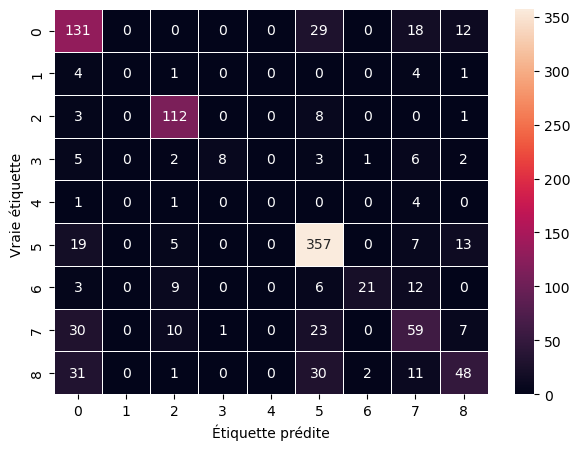

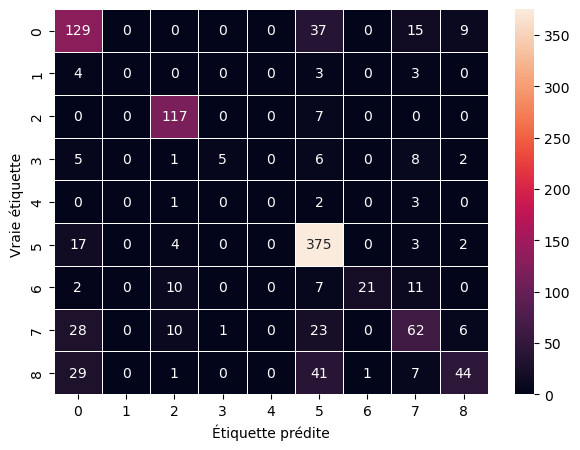

In [151]:
classes = [i for i in range(9)]

result_nb_lemma = train_and_test_classifier(train_json_fn, test_json_fn, model='NB', normalization='lemma')
print(f"Accuracy on training set with lemmatization: {result_nb_lemma['accuracy_train']}")
print(f"Accuracy on test set with lemmatization:: {result_nb_lemma['accuracy_test']}")
print(f"Execution time: {result_lr_lemma['execution_time']}")

display_confusion_matrix(result_nb_lemma["confusion_matrix"], classes)

result_nb = train_and_test_classifier(train_json_fn, test_json_fn, model='NB', normalization='words')
print(f"Accuracy on train set without lemmatization: {result_nb['accuracy_train']}")
print(f"Accuracy on test set without lemmatization: {result_nb['accuracy_test']}")
print(f"Execution time: {result_nb['execution_time']}")
display_confusion_matrix(result_nb["confusion_matrix"], classes)

### Logistic regression (with and without lemma)

Accuracy on train set with lemmatization: 0.7216161616161617
Accuracy on test set with lemmatization: 0.6016949152542372
Execution time: 103.94365811347961


Matrice de confusion
Accuracy on train set without lemmatization: 0.7244444444444444
Accuracy on test set without lemmatization : 0.7175141242937854
Execution time: 37.36099410057068


Matrice de confusion


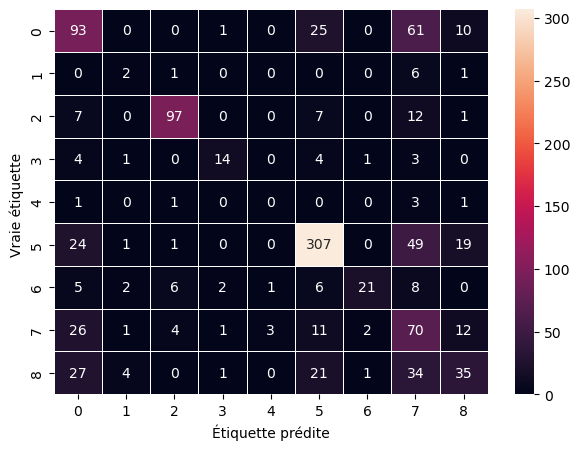

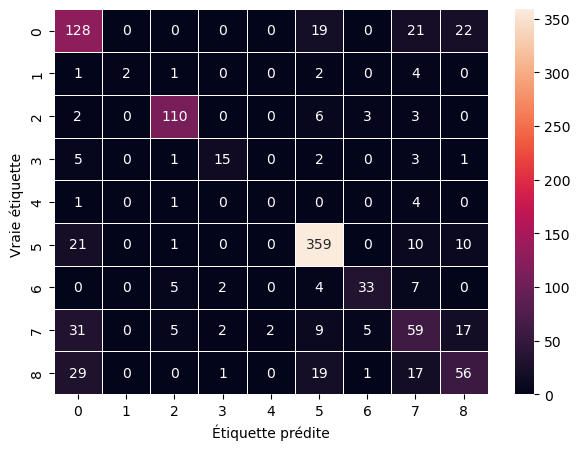

In [152]:
classes = [i for i in range(9)]

result_lr_lemma = train_and_test_classifier(train_json_fn, test_json_fn, model='LR', normalization='lemma')
print(f"Accuracy on train set with lemmatization: {result_lr_lemma['accuracy_train']}")
print(f"Accuracy on test set with lemmatization: {result_lr_lemma['accuracy_test']}")
print(f"Execution time: {result_lr_lemma['execution_time']}")

display_confusion_matrix(result_lr_lemma["confusion_matrix"], classes)

result_lr = train_and_test_classifier(train_json_fn, test_json_fn, model='LR', normalization='words')
print(f"Accuracy on train set without lemmatization: {result_lr['accuracy_train']}")
print(f"Accuracy on test set without lemmatization : {result_lr['accuracy_test']}")
print(f"Execution time: {result_lr['execution_time']}")
display_confusion_matrix(result_lr["confusion_matrix"], classes)


## Représentation grahique

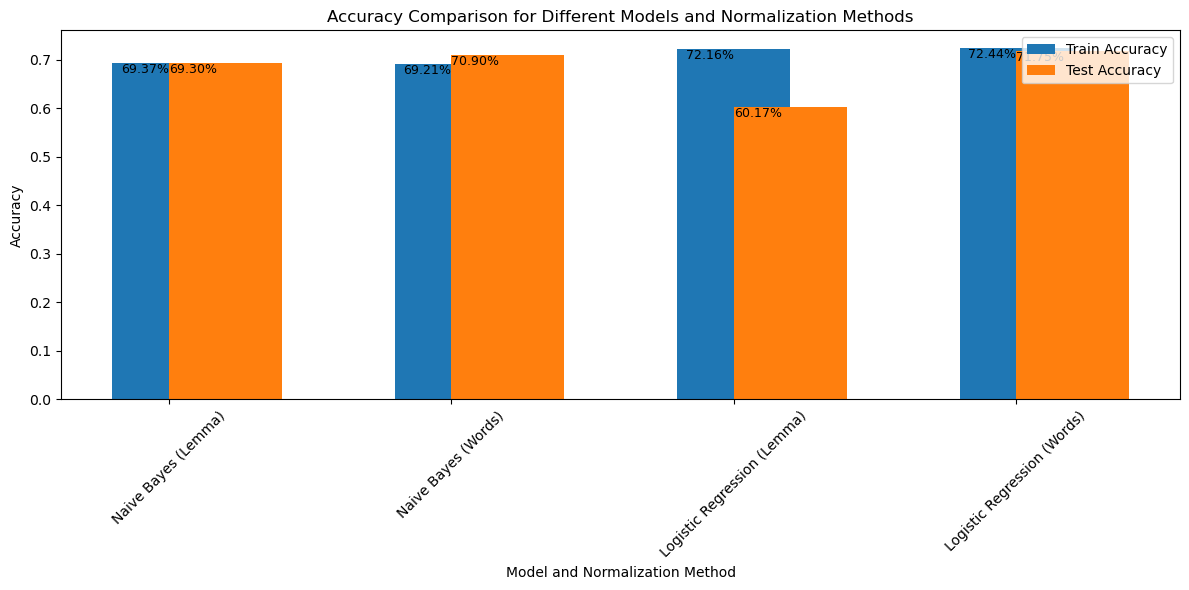

In [153]:
import matplotlib.pyplot as plt

# Define the model types and normalization methods
models = ['Naive Bayes (Lemma)', 'Naive Bayes (Words)', 'Logistic Regression (Lemma)', 'Logistic Regression (Words)']

# Define lists to store accuracy values for each model and train/test sets
train_accuracies = []
test_accuracies = []

# Append accuracy values to the respective lists
train_accuracies.append(result_nb_lemma['accuracy_train'])
test_accuracies.append(result_nb_lemma['accuracy_test'])

train_accuracies.append(result_nb['accuracy_train'])
test_accuracies.append(result_nb['accuracy_test'])

train_accuracies.append(result_lr_lemma['accuracy_train'])
test_accuracies.append(result_lr_lemma['accuracy_test'])

train_accuracies.append(result_lr['accuracy_train'])
test_accuracies.append(result_lr['accuracy_test'])

# Create a bar chart to compare accuracy values
plt.figure(figsize=(12, 6))

# Use a bar chart to compare train and test accuracies for each model
plt.bar(models, train_accuracies, label='Train Accuracy', width=0.4, align='center')
plt.bar(models, test_accuracies, label='Test Accuracy', width=0.4, align='edge')

# Add labels and legend
plt.xlabel('Model and Normalization Method')
plt.ylabel('Accuracy')
plt.legend()

# Add percentage values on top of the bars
for i, val in enumerate(train_accuracies):
    plt.text(i, val, f'{val:.2%}', va='top', ha='right', fontsize=9)

for i, val in enumerate(test_accuracies):
    plt.text(i, val, f'{val:.2%}', va='top', ha='left', fontsize=9)


# Show the plot
plt.title('Accuracy Comparison for Different Models and Normalization Methods')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Expliquez dans votre notebook les éléments suivants :
- ### Quelles sont les performances obtenues par chacun des classificateurs? Notez-vous des différences significatives au niveau de la performance et de l’exécution du code ?

Les performances des classificateurs ont été évaluées en utilisant deux méthodes de prétraitement des données : avec et sans la lemmatisation. Voici un résumé des performances obtenues pour chaque classificateur :

1. **Naive Bayes (avec Lemmatisation)** :
   - Précision pour l'ensemble d'entraînement : 69,37%
   - Précision pour l'ensemble de test : 69,30%
   - Execution time: 92.45865416526794

2. **Naive Bayes (sans Lemmatisation)** :
   - Précision pour l'ensemble d'entraînement : 69,21%
   - Précision pour l'ensemble de test : 70,90%
   - Execution time: 0.3487420082092285

3. **Régression Logistique (avec Lemmatisation)** :
   - Précision pour l'ensemble d'entraînement : 72,16%
   - Précision pour l'ensemble de test : 60,17%
   - Execution time: 103.94365811347961


4. **Régression Logistique (sans Lemmatisation)** :
   - Précision pour l'ensemble d'entraînement : 72,44%
   - Précision pour l'ensemble de test : 71,75%
   - Execution time: 37.36099410057068

En analysant ces résultats, plusieurs observations peuvent être faites :

- Pour Naive Bayes, l'utilisation de la lemmatisation n'a pas entraîné de différences significatives en termes de précision entre l'ensemble d'entraînement et l'ensemble de test. Les performances sont restées similaires, avec des précisions modérées.

- Cependant, il est intéressant de noter que, pour Naive Bayes, l'absence de lemmatisation a amélioré légèrement la précision sur l'ensemble de test, passant de 69,30% à 70,90%.

- Pour la Régression Logistique, l'utilisation de la lemmatisation a eu un impact négatif sur la performance, en particulier sur l'ensemble de test. La précision sur l'ensemble de test a diminué de manière significative par rapport à l'ensemble d'entraînement, indiquant que la Régression Logistique n'a pas réussi à exploiter pleinement le jeu de données lorsque la lemmatisation était appliquée.

- Cependant, lorsque la lemmatisation était absente, la Régression Logistique a montré des performances améliorées, avec une précision de 71,75% sur l'ensemble de test, ce qui est plus élevé que pour l'ensemble d'entraînement (72,44%). Cela indique une meilleure généralisation du modèle.

- Aussi, lorsque nous voulons utiliser un modele avec lemmatisation, le naif bayesien serait le meilleur choix car il donne des resultats moyennemment satisfaisants tandis que lorsque l'on ne veut pas faire recours à cette technique, la regression logistique donne les meilleurs resultats globaux.

- Enfin, nous avons constaté que les modèles qui n'utilisent pas de lemmatisation sans extremement plus rapides que lorsque l'on utilise ce procédé ( 3 fois plus rapide pour la regression logistique et preque 100 fois plus rapide pour le naif bayesien) 

En résumé, la Régression Logistique semble donner les meilleurs résultats globaux, en particulier lorsque la lemmatisation n'est pas utilisée, avec une meilleure capacité à généraliser à partir des données d'entraînement. Naive Bayes présente des performances modérées, avec une amélioration légère de la précision sur l'ensemble de test lorsqu'il n'y a pas de lemmatisation. La lemmatisation a un impact variable sur la performance en fonction du classificateur, mais en général, elle n'améliore pas significativement les résultats dans ce cas.

- ### Recommandez la configuration qui vous semble la plus intéressante.
En fonction des performances et des observations précédentes, voici une recommandation pour la configuration qui semble la plus intéressante :

**Configuration recommandée : Régression Logistique sans Lemmatisation**

La configuration qui semble la plus intéressante est d'utiliser la Régression Logistique sans lemmatisation. Voici les raisons de cette recommandation :

1. **Meilleure Performance Globale** : La Régression Logistique sans lemmatisation a obtenu les meilleures performances globales en termes de précision, avec une précision de 71,75% sur l'ensemble de test.

2. **Meilleure Capacité de Généralisation** : Cette configuration montre une meilleure capacité à généraliser à partir des données d'entraînement vers l'ensemble de test, ce qui indique un modèle plus robuste.

3. **Impact Positif sur le Test** : Contrairement à Naive Bayes, qui a légèrement bénéficié de la suppression de la lemmatisation, la Régression Logistique a montré des améliorations significatives sur l'ensemble de test sans la lemmatisation.

## Section 3 - À quoi correspondent les classes?

En utilisant les poids des modèles, tentez d'attribuer une signification aux différentes classes. Comme c'est une épreuve d'analyse de données, il est possible que certaines classes ne soient pas interprétables. Vous n'êtes pas tenu à l'impossible. L'important est d'utiliser ce qu'on observe dans les modèles pour fournir une explication.

Vous pouvez ajouter tout le code et toutes les cellules dont vous avez besoin.

##  Explicabilité du modèle

Nous avons décidé d'écrire un code pour faire ce qui suit:

- On extrait les informations importantes des modèles de classification (en particulier du modèle Naive Bayes) pour tenter d'attribuer une signification aux différentes classes. Voici comment il fonctionne :

1. Tout d'abord, le code récupère le modèle de classification (classifier) et le vectoriseur (vectorizer) à partir des résultats (result_nb) de l'apprentissage.

2. Il obtient ensuite les noms des caractéristiques (mots) à partir du vectorizer.

3. Ensuite, le code crée un DataFrame (features_df) pour stocker les mots et leurs probabilités logarithmiques de caractéristiques pour chaque classe.

4. Il extrait les probabilités logarithmiques de caractéristiques (feature_log_probs) du modèle de classification MultinomialNB pour chaque classe.

5. Le code ajoute des colonnes pour chaque classe avec leurs probabilités logarithmiques de caractéristiques respectives dans le DataFrame features_df.

6. Ensuite, il crée un dictionnaire (class_dataframes) pour stocker des DataFrames pour chaque classe, contenant les mots et leurs probabilités logarithmiques de caractéristiques supérieures au seuil spécifié de -7 (threshold).

7. Le code filtre les mots qui ont une probabilité logarithmique de caractéristiques inférieure au seuil et crée un DataFrame pour chaque classe avec les mots et les probabilités logarithmiques de caractéristiques supérieures au seuil.

 
À partir de ces DataFrames, on a pu analyser les mots qui ont des probabilités logarithmiques de caractéristiques élevées pour chaque classe. Ces mots sont ceux qui ont une influence significative sur la prédiction de chaque classe par le modèle. Nous avons essayé d'interpréter ces mots pour attribuer une signification aux différentes classes. Par exemple, notre code permet de voire que la classe 2 a beaucoup de mots qui tournent autour d'accidents dus a un choque electrique. Cela nous aide à comprendre ce que le modèle considère comme important pour chaque classe.

In [195]:
import nltk
from nltk.corpus import stopwords
#permet d'enlever les mots tels que "and" and "at"
stops = set(stopwords.words('english'))


In [194]:
import pandas as pd
import numpy as np
#pd.set_option('display.max_rows', None)

#trained and stored the result_nbs in 'result_nb'
classifier = result_lr['classifier']
vectorizer = result_lr['vectorizer']

# Get the feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Create a DataFrame to store the words and their feature log probabilities for each class
features_df = pd.DataFrame({'word': feature_names})

coefficients = classifier.coef_

# Convert coefficients to feature log probabilities
feature_log_probs = np.exp(coefficients)

# Extract feature log probabilities from the MultinomialNB classifier
# feature_log_probs = classifier.feature_log_prob_

# Add columns for each class with their respective feature log probabilities
for i, class_label in enumerate(classifier.classes_):
    features_df[class_label] = feature_log_probs[i]

# Now 'features_df' contains the words and their feature log probabilities for each class

# Create a dictionary to store DataFrames for each class
class_dataframes = {}

# Set a threshold for word selection (e.g., select words with a probability greater than or equal to a certain value)
threshold = 1.5  

# Loop through each class
for class_label in classifier.classes_:
    # Filter rows where the log probability is greater than or equal to the threshold
    filtered_df = features_df[(features_df[class_label] >= threshold)]
    
    # Create a DataFrame for this class with words and their log probabilities above the threshold
    class_dataframes[class_label] = filtered_df[['word', class_label]].rename(columns={class_label: 'Log Prob'})

# Now 'class_dataframes' contains DataFrames for each class with words and their log probabilities above the threshold

filtered_class_dataframes = {}

# Loop through each class
for class_label, class_df in class_dataframes.items():
    # Filter out words that are in the custom stopWords list
    filtered_df = class_df[~class_df['word'].isin(stops)]
    
    # Add the filtered DataFrame to the new dictionary
    filtered_class_dataframes[class_label] = filtered_df


### Accident Involving Heavy Machinery

In [196]:
filtered_class_dataframes['0']
# Accident Involving Heavy Machinery

,word,Log Prob
754,aerial,1.525579
1178,backing,1.734684
1671,cab,1.513365
1814,cathead,1.642102
1820,caught,1.715363
1836,caved,1.758885
1949,chipper,1.572143
2118,collapse,1.558587
2119,collapsed,2.858510
2143,columns,1.647222


### Drowning incident

In [182]:
filtered_class_dataframes['1']
# Drowning

,word,Log Prob
1232,barge,2.081154
2106,coffer,1.505061
2601,dam,1.505056
2931,diver,1.509035
3051,drowned,2.693318
7374,river,1.517936


### Accident Involving electricity

In [183]:
filtered_class_dataframes['2']
# electical accident

,word,Log Prob
1637,bus,1.920677
2304,contact,2.281704
2305,contacted,2.716426
3169,electric,1.570851
3170,electrical,1.734773
3178,electrocuted,9.108305
3180,electrocution,1.508780
3253,energized,2.733151
5233,line,1.643406
6150,overhead,2.254696


### Accident Involving gaz leak

In [184]:
filtered_class_dataframes['3']


,word,Log Prob
216,2011,1.633862
1051,asphyxia,2.142264
1052,asphyxiated,1.744848
1744,carbon,1.524132
1953,chloride,1.675131
3957,gas,2.026021
4665,inhalation,1.575728
5589,methylene,1.675131
5728,monoxide,1.518198
6140,overcome,1.744084


###  Employee Injured in Hot fluid Accident

In [185]:
filtered_class_dataframes['4']
# employee burned by hot water

,word,Log Prob
208,2005,1.620293
1625,burned,1.883751
2701,degrees,1.618695
3515,fahrenheit,1.615859
4288,heat,2.000560
4436,hot,1.722747
4737,insulation,1.568536
8317,steam,1.524241
8771,temperature,1.667422
9756,worker,1.632335


### Fall accident

In [186]:
filtered_class_dataframes['5']
# Heigh fall from building construction

,word,Log Prob
102,15,1.505025
229,21,1.640689
1200,balance,2.696400
1498,bracket,1.658229
2179,company,1.671976
3160,ejected,1.511817
3529,fall,2.381811
3586,feet,2.238502
3587,fell,7.600255
3843,fractured,1.796327


### Fire and explosion incident

In [187]:
filtered_class_dataframes['6']
# Fire and explosion incident

,word,Log Prob
992,arc,1.541994
1630,burns,2.621219
2091,coal,1.571443
3433,exploded,1.937341
3436,explosion,2.261678
3573,february,1.525848
3649,fire,2.591919
3898,fuel,1.664788
3957,gas,2.266927
4433,hospitalized,1.654616


### Lesions causées par des équipements

In [188]:
filtered_class_dataframes['7']
# Container explosion

,word,Log Prob
247,23,1.649157
1030,arrows,1.507587
1158,away,1.630842
1630,burns,1.783339
1786,case,1.842909
1828,caused,1.575222
2239,condition,1.592951
2630,days,1.589614
2654,december,1.624144
2847,directing,1.684928


### Percuted by something

In [189]:
filtered_class_dataframes['8']
# Percuted by something

,word,Log Prob
209,2006,1.556861
214,2009,1.566547
218,2013,1.731418
892,amputating,1.506758
1278,beam,1.799572
1410,blocking,1.917547
1673,cabinet,1.543937
2420,counterweight,1.769206
3059,drywall,1.533254
3190,elevator,2.029892


## Section 4 - Section réservée pour nos tests (ne pas modifier)